# Synthetic expression data from hematopoiesis network

In [1]:
import pandas as pd
import numpy as np
import random
from colomoto.minibn import * # for Boolean network manipulation
import networkx as nx # for graph manipulation
from scboolseq import scBoolSeq

# set seed for reproducible results
_rng_seed = 1834650
# use a Generator instead of numpy's singleton
_rng = np.random.default_rng(_rng_seed)
random.seed(_rng_seed)

This notebook has been executed using the docker image `bnediction/scboolseq:v0`

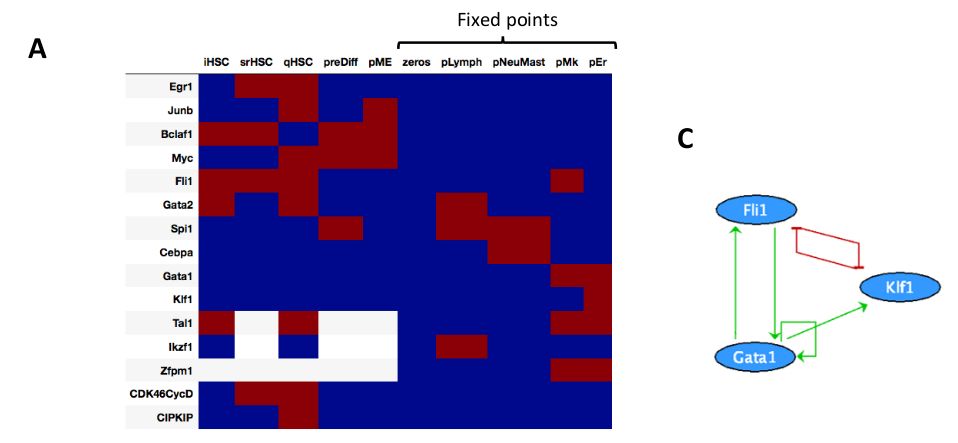


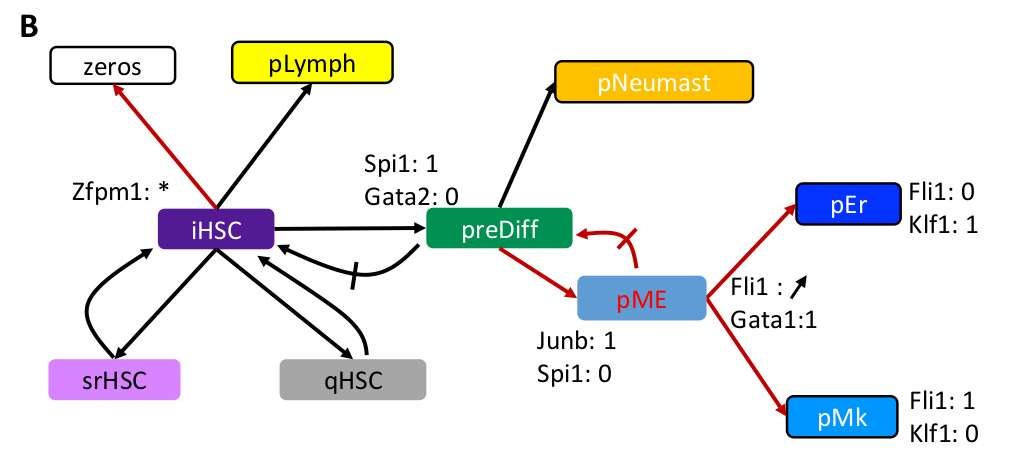

## Load Boolean network

In [2]:
bn = BooleanNetwork.load("models/herault_hematopoiesis.bnet")
bn

Bclaf1 <- Myc
CDK46CycD <- Bclaf1|Myc
CIPKIP <- Junb
Cebpa <- (Gata2&!Ikzf1)|(Spi1&!Ikzf1)
Egr1 <- Gata2&Junb
Fli1 <- Junb|(Gata1&!Klf1)
Gata1 <- Fli1|(Gata2&!Spi1)|(Gata1&!Ikzf1&!Spi1)
Gata2 <- (Gata2&!Gata1&!Zfpm1)|(Egr1&!Gata1&!Zfpm1&!Spi1)
Ikzf1 <- Gata2
Junb <- Egr1|Myc
Klf1 <- Gata1&!Fli1
Myc <- Cebpa&Bclaf1
Spi1 <- (Spi1&!Gata1)|(Cebpa&!Gata1&!Gata2)
Tal1 <- Gata1&!Spi1
Zfpm1 <- Gata1

# computing graph layout...


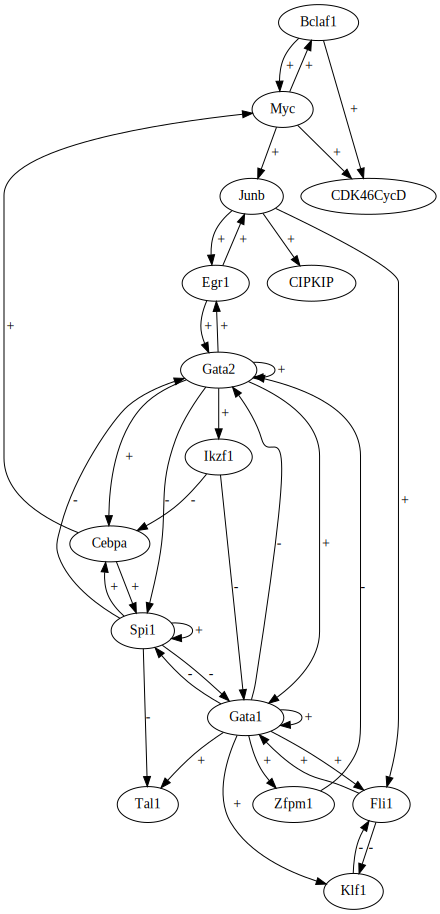

In [3]:
bn.influence_graph()

## Extract trajectories from the state transition graph

XXXX EXPLAIN

In [4]:
iHSC_active = {"Bclaf1","Fli1","Gata2","Tal1","Zfpm1"}
preDiff_active = {"Bclaf1", "Myc", "Spi1", "Zfpm1", "Tal1", "Ikzf1"}
pNeumast_active = {"Spi1", "Cebpa"}
pMk_active = {"Fli1", "Gata1", "Tal1", "Zfpm1"}
pEr_active = {"Klf1", "Gata1", "Tal1", "Zfpm1"}

def state_from_active(active):
    assert set(active).issubset(bn)
    return {n: int(n in active) for n in bn}

iHSC = state_from_active(iHSC_active)
preDiff = state_from_active(preDiff_active)
pNeumast = state_from_active(pNeumast_active)
pMk = state_from_active(pMk_active)

pd.DataFrame([iHSC, preDiff, pNeumast, pMk])

,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1
1,1,0,0,0,0,0,0,0,1,0,0,1,1,1,1
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1


We compute the state transition graph from the initial state, using the fully asynchronous update mode:

In [5]:
dynamics = FullyAsynchronousDynamics(bn)
stg = dynamics.partial_dynamics(iHSC)
len(stg)

10680

In [6]:
# utility function toa query the state-transition graph
def node_of_state(state):
    # convert a dict state to the binary representation
    return "".join([str(state[node]) for node in dynamics.nodes])
def state_of_node(name):
    # convert the binary representation of a state to a dict
    return dict(zip(dynamics.nodes, map(int, name)))

init = node_of_state(iHSC)
branching = node_of_state(preDiff)
phenotype1 = node_of_state(pNeumast)
phenotype2 = node_of_state(pMk)

In [7]:
common = nx.shortest_path(stg, init, branching)
traj1 = nx.shortest_path(stg, branching, phenotype1)[1:]
traj2 = nx.shortest_path(stg, branching, phenotype2)[1:]
binstates = pd.DataFrame(map(state_of_node, common+traj1+traj2))

# label the states
labels = ["init"]\
         + [f"common.{i}" for i in range(1,len(common)-1)] + ["switch"]\
         + [f"branch1.{i}" for i in range(len(traj1)-1)] + ["pNeumast"] \
         + [f"branch2.{i}" for i in range(len(traj2)-1)] + ["pMk"]
binstates.index = labels
binstates.index.name = "label"

binstates

,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
label,,,,,,,,,,,,,,,
init,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1
common.1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,1
common.2,1,0,0,1,0,1,0,1,1,0,0,0,0,1,1
common.3,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1
common.4,1,0,0,1,0,1,0,0,1,0,0,1,0,1,1
common.5,1,0,0,1,0,1,0,0,1,0,0,1,1,1,1
common.6,1,0,0,1,0,0,0,0,1,0,0,1,1,1,1
switch,1,0,0,0,0,0,0,0,1,0,0,1,1,1,1
branch1.0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1


## Retrieve statistics of real expression datasets

We re-use statistics computed from a real scRNA-Seq dataset ([1 - Binarization and synthetic data generation](1%20-%20Binarization%20and%20synthetic%20data%20generation.ipynb)):

In [8]:
criteria = pd.read_csv("cache_scBoolSeq_Nestorowa_simulation_criteria.csv", index_col=0)
criteria.head()

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category,dor_threshold
Clec1b,9.948487e-01,1.635698,6.166711,0.876208,1.520978,-0.007249,8.852181,0.986140,0.013860,0.111291,5.666490,0.157649,1.520978,2.666760,0.25,0.667271,1.555290,0.888020,0.968776,2.785740,3.094168,Unimodal,NaN
Kdm3a,0.000000e+00,2.407548,-0.784019,0.326087,3.847940,0.209239,10.126676,0.714520,0.285480,0.872643,6.899449,1.278247,2.593177,8.692586,0.25,0.000000,5.258984,5.258984,1.268040,3.432251,4.748643,Bimodal,0.95
Coro2b,4.684039e-03,2.320060,0.327060,0.658213,2.383819,0.004597,9.475577,0.919508,0.080492,0.335546,6.289079,0.487372,2.383819,5.370521,0.25,0.827740,2.912944,2.085205,1.290666,3.183596,3.879537,Bimodal,NaN
8430408G22Rik,7.236739e-08,3.121069,-0.993979,0.884058,2.983472,0.005663,9.067857,0.964962,0.035038,0.098898,7.148808,0.172506,2.983472,8.154647,0.25,0.825298,6.465074,5.639776,1.449779,3.612061,4.175572,Bimodal,NaN
Clec9a,1.000000e+00,2.081717,140.089285,0.965580,2.280293,-0.009361,9.614233,0.993961,0.006039,0.035599,7.138099,0.069870,0.078488,0.372878,0.25,0.000000,0.000000,0.000000,0.000000,3.113410,4.607253,Discarded,0.95


In [9]:
criteria.Category.value_counts()

Bimodal      2987
Unimodal     1580
Discarded     201
Name: Category, dtype: int64

We randomly select bimodal genes for each of the nodes of the Boolean model to obtain simulation criteria:

In [10]:
pd.Series(bn.keys())

0        Bclaf1
1     CDK46CycD
2        CIPKIP
3         Cebpa
4          Egr1
5          Fli1
6         Gata1
7         Gata2
8         Ikzf1
9          Junb
10         Klf1
11          Myc
12         Spi1
13         Tal1
14        Zfpm1
dtype: object

In [11]:
random_criteria = criteria[
    (criteria.Category == "Bimodal") &
    (criteria.DropOutRate < 0.05)
].sample(len(bn), random_state=_rng_seed)
random_criteria.set_index(pd.Series(bn.keys()), inplace=True)
random_criteria

,Dip,BI,Kurtosis,DropOutRate,MeanNZ,DenPeak,Amplitude,gaussian_prob1,gaussian_prob2,gaussian_mean1,gaussian_mean2,gaussian_variance,mean,variance,unimodal_margin_quantile,unimodal_low_quantile,unimodal_high_quantile,IQR,q50,bim_thresh_down,bim_thresh_up,Category,dor_threshold
Bclaf1,0.000000,2.271052,-1.434132,0.042271,5.525398,7.997457,10.713603,0.440906,0.559094,2.167851,7.755440,1.492195,5.291836,9.194007,0.25,2.309364,7.989371,5.680008,6.070933,4.113816,5.689417,Bimodal,0.95
CDK46CycD,0.000000,2.458249,-1.169238,0.012077,6.497481,8.571923,11.316913,0.349107,0.650893,2.659834,8.435248,1.254246,6.419009,8.838978,0.25,3.310739,8.791162,5.480423,7.723260,4.763775,6.055640,Bimodal,0.95
CIPKIP,0.000000,2.183097,-1.325437,0.028382,5.734833,8.215905,10.948014,0.404924,0.595076,2.363242,7.755543,1.470106,5.572069,8.481619,0.25,2.656601,8.173665,5.517064,6.458349,4.147389,5.759331,Bimodal,0.95
Cebpa,0.000000,1.931030,-1.334292,0.009058,5.460154,8.069132,11.453356,0.466175,0.533825,2.764287,7.721736,1.640161,5.410696,7.760802,0.25,2.770575,7.924481,5.153906,5.738153,4.213156,6.174692,Bimodal,0.95
Egr1,0.000000,1.919708,-1.240142,0.006039,5.045228,2.715502,10.707136,0.542556,0.457444,3.037230,7.360232,1.258587,5.014761,5.900391,0.25,2.828525,7.168048,4.339523,4.627248,4.389391,6.109265,Bimodal,0.95
Fli1,0.017757,1.880105,-0.715022,0.014493,6.175882,7.827801,12.188733,0.291542,0.708458,2.477742,7.571391,1.516035,6.086376,6.879063,0.25,4.094686,8.085153,3.990467,7.035218,3.864529,5.639595,Bimodal,0.95
Gata1,0.000799,1.996111,-0.811197,0.010870,6.644838,8.547279,10.862485,0.304173,0.695827,2.804285,8.219897,1.557929,6.572611,7.770130,0.25,4.114726,8.749374,4.634648,7.668843,4.427154,6.133252,Bimodal,0.95
Gata2,0.000013,1.988938,-0.690510,0.013889,3.980944,2.456629,10.494881,0.713916,0.286084,2.590485,7.257539,1.124562,3.925653,5.576557,0.25,2.164421,5.850608,3.686187,3.048213,4.403067,5.859924,Bimodal,0.95
Ikzf1,0.000000,2.453467,-1.230807,0.030193,6.075780,8.135823,11.060932,0.371567,0.628433,2.308770,8.011153,1.261387,5.892333,8.859662,0.25,2.892557,8.312092,5.419534,7.233742,4.369993,5.707568,Bimodal,0.95
Junb,0.000000,2.261481,-1.293139,0.036836,5.897349,8.182441,10.672184,0.383762,0.616238,2.224230,7.832271,1.454276,5.680115,8.897251,0.25,2.640922,8.250504,5.609582,6.832647,4.125103,5.672774,Bimodal,0.95


## Generate synthetic RNA-Seq data

In [12]:
scbool = scBoolSeq(simulation_criteria=random_criteria)
scbool

scBoolSeq(has_data=False, can_binarize=False, can_simulate=True)

In [13]:
binstates.index[len(common)-1+len(traj1)]

'pNeumast'

In [14]:
n_samples = _rng.integers(150, 200, size=len(binstates))
n_samples[[len(common)-1+len(traj1),-1]] = _rng.integers(450, 600, size=2)
n_samples

array([184, 193, 174, 154, 157, 171, 189, 168, 185, 177, 156, 193, 179,
       596, 196, 189, 151, 152, 150, 158, 163, 530])

In [15]:
d = np.array(binstates).repeat(n_samples, axis=0)
bindata = pd.DataFrame(d, columns=binstates.columns)
bindata.shape

(4565, 15)

In [16]:
counts = scbool.simulate(bindata, n_samples=1, seed=2937283)
counts.head()

,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
0,7.272742,3.072821,2.934519,2.567695,3.259322,5.422549,2.629122,7.000062,0.000000,1.870571,4.712892,2.920175,3.409321,10.210090,6.770100
1,9.379227,2.376855,1.156308,4.325819,3.084068,5.812863,0.882373,7.408340,3.165181,1.207526,3.234981,1.426510,1.973566,8.284458,9.110103
2,8.758629,3.216206,3.046133,3.298777,4.463747,3.847351,3.141744,5.501506,4.389592,3.528886,1.513940,0.787874,2.468283,8.840823,8.102119
3,7.751030,4.050580,1.581995,3.131279,1.687493,7.572249,3.250772,6.161751,3.724161,2.012807,3.131493,3.055190,4.890452,8.475564,7.072808
4,7.048156,2.626252,3.033596,2.893697,2.338154,5.663830,3.684135,7.976371,1.823105,2.077562,3.692950,2.194984,4.189439,8.866758,7.192732


In [17]:
counts.shape

(4565, 15)

We generate unique identifiers for each row (cell):

In [18]:
ids = [f"{x}_{y}"  for i,x in enumerate(binstates.index) for y in range(n_samples[i])]
counts.index = ids
counts.index.name = "cellID"
counts

,Bclaf1,CDK46CycD,CIPKIP,Cebpa,Egr1,Fli1,Gata1,Gata2,Ikzf1,Junb,Klf1,Myc,Spi1,Tal1,Zfpm1
cellID,,,,,,,,,,,,,,,
init_0,7.272742,3.072821,2.934519,2.567695,3.259322,5.422549,2.629122,7.000062,0.000000,1.870571,4.712892,2.920175,3.409321,10.210090,6.770100
init_1,9.379227,2.376855,1.156308,4.325819,3.084068,5.812863,0.882373,7.408340,3.165181,1.207526,3.234981,1.426510,1.973566,8.284458,9.110103
init_2,8.758629,3.216206,3.046133,3.298777,4.463747,3.847351,3.141744,5.501506,4.389592,3.528886,1.513940,0.787874,2.468283,8.840823,8.102119
init_3,7.751030,4.050580,1.581995,3.131279,1.687493,7.572249,3.250772,6.161751,3.724161,2.012807,3.131493,3.055190,4.890452,8.475564,7.072808
init_4,7.048156,2.626252,3.033596,2.893697,2.338154,5.663830,3.684135,7.976371,1.823105,2.077562,3.692950,2.194984,4.189439,8.866758,7.192732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pMk_525,1.510117,0.020060,1.066910,1.254402,1.014852,7.484866,6.820082,2.535112,2.072533,2.271591,5.111077,5.073930,3.833110,8.419687,8.315857
pMk_526,1.920005,2.199807,2.632398,0.767549,4.747743,8.461331,8.275822,2.539642,2.498187,0.000000,4.524242,3.527308,1.533670,7.264833,8.684284
pMk_527,0.000000,4.641946,0.909853,4.823950,5.072551,8.708967,7.288631,3.069511,1.151833,0.711935,4.181181,1.628130,1.289232,6.442578,9.046492


Write as TSV file:

In [19]:
counts.T.to_csv("synthetic_data_hematopoiesis_counts.tsv", sep="\t")

We generate metadata to validate a trajectory reconstruction:

In [20]:
def label_of_index(idx):
    return idx.split(".")[0]
labels = [label_of_index(idx) for idx in binstates.index]

color_map = {
    "init": "#550000",
    "common": "#aec7e8",
    "switch": "#1f78b4",
    "branch1": "#98df8a",
    "pNeumast": "#2ca02c",
    "branch2": "#ff9896",
    "pMk": "#d62728",
}

In [21]:
metadata = [[l, color_map[l]] for i,l in enumerate(labels) for _ in range(n_samples[i])]
metadata = pd.DataFrame(metadata, columns=["label", "label_color"])
metadata.index = counts.index
metadata

,label,label_color
cellID,,
init_0,init,#550000
init_1,init,#550000
init_2,init,#550000
init_3,init,#550000
init_4,init,#550000
...,...,...
pMk_525,pMk,#d62728
pMk_526,pMk,#d62728
pMk_527,pMk,#d62728


In [22]:
metadata.to_csv("synthetic_data_hematopoiesis_metadata.tsv", sep="\t")